
This script's purpose is to conduct an empirical investigation into the effects of different learning rate magnitudes on the training stability and convergence speed of a neural network language model. It involves initializing models with distinct learning rate ranges—high, medium, and low—and observing the resulting Update Divergence (UD) values, which serve as indicators of learning stability. The experiment aims to discern an optimal learning rate that balances the trade-off between rapid model convergence and the stability of gradient updates across the network's layers. This is visualized through plots that capture the oscillation and stabilization of gradients, offering insights into the relationship between learning rate settings and model training dynamics.


---

The code cell below imports essential libraries for developing neural network models with PyTorch, alongside tools for data handling, visualization, text processing, and configuration management. It ensures the availability of functions for mathematical calculations, system operations, and date-time handling, which are integral to machine learning workflows.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict, Counter
import string
import yaml
import json
import math 
import sys
from collections import defaultdict




---

The code cell below reads configuration parameters from a YAML file for a neural network training setup. It specifies dataset paths, data preprocessing requirements, runtime parameters, and hyperparameters for the training experiment. These settings are integral to the training process, influencing the network's architecture and learning dynamics.

In [2]:
with open("learningRateAnalyticsConfig.yaml", 'r') as ymlfile:
    config = yaml.safe_load(ymlfile)

training_data_corpus_path = config['data']['training_data_corpus_path']
validation_data_corpus_path = config['data']['validation_data_corpus_path']
test_data_corpus_path = config['data']['test_data_corpus_path']
min_freq = config['data']['min_freq']
context_size = config['data']['context_size']

shuffle = config['runtime']['shuffle']
num_workers = config['runtime']['num_workers']
batch_size = config['runtime']['batch_size']
config_device = config['runtime']['device']


total_epochs = config['experiment']['total_epochs']
weight_decay = config['hyperparameters']['weight_decay']
reduction_factor = config['hyperparameters']['reduction_factor']
numberOfLayers = config['hyperparameters']['numberOfLayers'] # Number of hidden layers
embed_size = config['hyperparameters']['embed_size']  # The embedding size of the words 
hidden_size = config['hyperparameters']['hidden_size'] # The hidden size of the neural network



---

The `WikiText2VocabBuilder` class in the provided code cell processes a text corpus to build a vocabulary. It reads the corpus, tokenizes the text, counts word frequencies, and sets up indices for each unique word, including specified special tokens. The vocabulary is formed based on a minimum frequency criterion for words, ensuring that infrequent words are excluded. This class is essential for the initial step in preparing data for language modeling tasks.

In [4]:
class WikiText2VocabBuilder:
    def _new_index(self):
        return len(self.word2index)
    
    def __init__(self, corpus_path, min_freq):
        self.corpus_path = corpus_path
        self.min_freq = min_freq
        self.word2index = defaultdict(self._new_index)
        self.index2word = {}
        self.word_freqs = Counter()
        self.cleaned_sentences = []
        
        self.START_TOKEN = "<s>"
        self.END_TOKEN = "</s>"
        self.UNK_TOKEN = "<unk>"
        self.hyphentoken = "hyphentoken"
        self.numericalcommatoken = "numericalcommatoken"

        self._initialize_special_tokens()
        self._load_and_preprocess()
        
    def _initialize_special_tokens(self):
        self.word2index[self.START_TOKEN] = 0
        self.word2index[self.END_TOKEN] = 1
        self.word2index[self.UNK_TOKEN] = 2
        self.word2index[self.hyphentoken] = 3
        self.word2index[self.numericalcommatoken] = 4

        self.index2word[0] = self.START_TOKEN
        self.index2word[1] = self.END_TOKEN
        self.index2word[2] = self.UNK_TOKEN
        self.index2word[3] = self.hyphentoken
        self.index2word[4] = self.numericalcommatoken
       
        
    def clean_and_tokenize(self, corpus):
        corpus = corpus.lower()  # Convert to lowercase
        sentences = sent_tokenize(corpus)
        cleaned_sentences = []
        for sentence in sentences:
            sentence = sentence.strip()  # Remove unnecessary whitespaces
            if not (sentence.startswith('=') or sentence.endswith('=')):  # Exclude headers
                sentence = sentence.replace('<unk>', 'unknowntoken')  
                sentence = sentence.replace('@-@', 'hyphentoken')  
                sentence = sentence.replace('@,@', 'numericalcommatoken')  
                cleaned_sentences.append(sentence)
        return cleaned_sentences
    
    def _load_and_preprocess(self):
        with open(self.corpus_path, 'r') as f:
            corpus = f.read()
        
        # Split the text into sentences using NLTK
        self.cleaned_sentences = self.clean_and_tokenize(corpus)
        # Count word frequencies
        for sentence in self.cleaned_sentences:
            words = word_tokenize(sentence)
            for word in words:
                word = word.lower()
                self.word_freqs[word] += 1
        
        # Build the vocabulary using only words that meet the frequency threshold
        for word, freq in self.word_freqs.items():
            if freq >= self.min_freq:
                index = self.word2index[word]
                self.index2word[index] = word
                
    def vocab_size(self):
        return len(self.word2index)



In [5]:
class WikiText2Dataset(Dataset):
    def __init__(self, preprocessor, context_size):
        super(WikiText2Dataset, self).__init__()

        self.context_size = context_size

        # We already have cleaned sentences in the preprocessor
        self.sentences = preprocessor.cleaned_sentences
        self.word2index = preprocessor.word2index
        self.index2word = preprocessor.index2word
        self.word_freqs = preprocessor.word_freqs
        self.START_TOKEN = preprocessor.START_TOKEN
        self.END_TOKEN = preprocessor.END_TOKEN
        self.UNK_TOKEN = preprocessor.UNK_TOKEN
        self.hyphentoken = preprocessor.hyphentoken
        self.numericalcommatoken = preprocessor.numericalcommatoken


        self.X, self.Y = self._build_dataset()

    def _build_dataset(self):
        X, Y = [], []
        
        for sentence in self.sentences:
            words = word_tokenize(sentence)
            if not words:
                continue
            if words[-1] in string.punctuation:
                words[-1] = self.END_TOKEN
            else:
                words.append(self.END_TOKEN)
            
            context = [0] * self.context_size
            for i, word in enumerate(words):
                
                if word in self.word2index and word not in ['unknowntoken', 'hyphentoken', 'numericalcommatoken']:
                    index = self.word2index[word]
                elif word == 'unknowntoken':
                    index = self.word2index[self.UNK_TOKEN]
                elif word == 'hyphentoken':
                    index = self.word2index[self.hyphentoken]
                elif word == 'numericalcommatoken':
                   index = self.word2index[self.numericalcommatoken]
                else:
                    index = self.word2index[self.UNK_TOKEN]
                X.append(context)
                Y.append(index)
                context = context[1:] + [index]
        
        return torch.tensor(X), torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def sample(self, num_samples):
        for _ in range(num_samples):
            idx = torch.randint(0, len(self), (1,)).item()
            context, target = self.X[idx], self.Y[idx]
            context_words = [self.index2word[i.item()] for i in context]
            target_word = self.index2word[target.item()]
            print(" ".join(context_words), "------>", target_word)
    
    def get_context_size(self):
        return self.context_size



---

The code cell initializes a `WikiText2VocabBuilder` object with parameters for the corpus path and minimum word frequency. Utilizing this builder, it then creates `WikiText2Dataset` objects for training, validation, and testing. These datasets will serve as the input for training a language model, encapsulating the context size specified for the model's architecture.

In [6]:
train_vocabBuilder =  WikiText2VocabBuilder(corpus_path = training_data_corpus_path, min_freq=min_freq)

train_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)
valid_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)
test_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)



---

The code cell below configures `DataLoader` instances for the training, validation, and testing sets using the previously defined `WikiText2Dataset` objects. These loaders are tailored with batch size, shuffle state, and worker count for handling data during the neural network's training process.

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)



The code cell below implements a neural network with custom layers for linear transformation, Tanh activation, and Layer Normalization. These components are incorporated into a language model that processes input data through embeddings, sequential hidden layers, and an output layer to generate log probabilities. The model is designed with the flexibility to specify the number of layers, embedding size, and other hyperparameters, which are crucial for its learning capacity and performance.

In [8]:
class Linear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim))
        self.bias = nn.Parameter(torch.Tensor(self.output_dim))
        for param in self.parameters():
            param.requires_grad = True
            
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.constant_(self.bias, 0)

    def forward(self, x):
        self.out = torch.matmul(x, self.weight) + self.bias
        return self.out

class Tanh(nn.Module):
    def __init__(self):
        super(Tanh, self).__init__()
    

    def forward(self, x):
        self.out = torch.tanh(x)
        self.out.retain_grad()
        return self.out

class LayerNorm(nn.Module):
    def __init__(self, hidden_size):
        super(LayerNorm, self).__init__()
        self.hidden_size = hidden_size
        self.weight = nn.Parameter(torch.Tensor(self.hidden_size))
        self.bias = nn.Parameter(torch.Tensor(self.hidden_size))
        for param in self.parameters():
            param.requires_grad = True
            
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.weight, 1)
        nn.init.constant_(self.bias, 0)

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        self.out = self.weight * (x - mean) / (std + 1e-8) + self.bias
        return self.out

class LanguageModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, context_size, numberOfLayers):
        super(LanguageModel, self).__init__()
        self.embed_size = embed_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.numberOfLayers = numberOfLayers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_layers = nn.ModuleList()


        # Hidden layers weights, bias, and layer normalization
        for i in range(self.numberOfLayers):
            linear_layer = Linear((self.context_size) * self.embed_size if i == 0 else self.hidden_size, self.hidden_size)
            layer = [linear_layer]
            layer_norm = LayerNorm(self.hidden_size)
            layer.append(layer_norm)
            layer.append(Tanh())
           
            self.hidden_layers.append(nn.Sequential(
                *layer
            ))
            
        self.output_layer = nn.Linear(self.hidden_size, self.vocab_size)
          
        with torch.no_grad():
            # Make the output layer less confident
            nn.init.constant_(self.output_layer.weight, 0.0001)
            nn.init.constant_(self.output_layer.bias, 0)
        
        parameters = [self.embedding.weight] + \
             [param for layer in self.hidden_layers for param in [layer[0].weight, layer[0].bias]] + \
             [self.output_layer.weight, self.output_layer.bias]

        self.parameters = nn.ParameterList(parameters)
   
    def forward(self, x): 
        x = self.embedding(x) # Retrieve the corresponding embeddings  
        x = x.view(x.size(0), -1)  

        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)

        # Output layer computation. The output is of shape (batch_size, vocab_size)
        y = self.output_layer(x)

        # Log probabilities (logits). Log probs is of shape (batch_size, vocab_size)
        log_probs = F.log_softmax(y, dim=1)
        
        return log_probs
        
    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


The code cell below defines a training function for a language model, terminating after 1000 steps. This function utilizes the Adam optimizer, a learning rate scheduler, and logs loss values. It computes and records a gradient statistic that reflects the scaling effect of the learning rate on gradient values, expressed as the ratio of their standard deviations. This statistic can provide insights into the training dynamics, indicating how well the learning rate is facilitating convergence and whether adjustments to the rate are leading to more stable and consistent updates across training iterations.

In [9]:

def train_language_model(model, train_dataloader, valid_dataloader, test_dataloader, device, total_epochs, start_lr, end_lr, weight_decay_value):  
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=start_lr, weight_decay=weight_decay_value)
    scheduler = ExponentialLR(optimizer, gamma=(end_lr/start_lr)**(1/total_epochs))
    lossi = []
    ud = []

    max_steps = 1000
    train_dataloader_iterator = iter(train_dataloader)

    
    for i in range(max_steps):
        try:
        # Fetch the next batch of data
           contexts, targets = next(train_dataloader_iterator)
        except StopIteration:
            # Reinitialize the iterator if the entire dataset has been processed
            train_dataloader_iterator = iter(train_dataloader)
            contexts, targets = next(train_dataloader_iterator)
    
           
        # Move the data to the GPU
        contexts, targets = contexts.to(device), targets.to(device)
        log_probs = model(contexts)
        loss = loss_function(log_probs, targets)

        for layer in model.hidden_layers:
            for hidden_layer in layer:
                if isinstance(hidden_layer, Linear):
                    hidden_layer.out.retain_grad()
        
                    
        for p in model.parameters():
            if p.grad is not None:
                p.grad.zero_()    
     
        # Backward pass
        loss.backward()
        optimizer.step()

        lossi.append(loss.log10().item())
        # Inside your while loop, after the backward pass
        with torch.no_grad():
            lr = scheduler.get_last_lr()[0]
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in [p for p in model.parameters()]])
    
    return lossi, ud
    


The code cell below launches a training experiment to investigate the effects of different magnitudes of learning rates on a neural language model's training effectiveness. It establishes three separate training scenarios with high, medium, and low learning rate ranges, intending to observe how these rates influence the initial convergence behavior and gradient updates of the model. This systematic approach allows for the analysis of learning rate effectiveness across different scales, providing insights into the optimization process tailored to the model's architecture.

In [10]:

vocab_size = train_vocabBuilder.vocab_size() # The size of the vocabulary

# Initialize device based on the configuration and availability
device = torch.device(config_device if torch.cuda.is_available() else "cpu")
device_msg = f"Used Device: {device}"
logging.info(device_msg)
print(device_msg)
valid_perplexities_dict = {}
test_perplexity_dict = {}

np.random.seed(423455335)
# Set the seed for generating random numbers
torch.manual_seed(423455335)
# Set the seed for generating random numbers for CUDA when using the GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


modelHigh = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers)
modelHigh = modelHigh.to(device)
lr_startHigh = 0.1
lr_endHigh = 0.01
lossiHigh, udHigh =  train_language_model(model=modelHigh, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_startHigh, end_lr=lr_endHigh, weight_decay_value=weight_decay)   

lr_startMedium = 0.0001
lr_endMedium = 0.00001
modelMedium = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers)
modelMedium = modelMedium.to(device)
lossiMedium, udMedium =  train_language_model(model=modelMedium, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_startMedium, end_lr=lr_endMedium, weight_decay_value=weight_decay)

lr_startLow = 0.0000001
lr_endLow = 0.00000001
modelLow = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers)
modelLow = modelLow.to(device)
lossiLow, udLow =  train_language_model(model=modelLow, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_startLow, end_lr=lr_endLow, weight_decay_value=weight_decay)

Used Device: cuda



The code cell below illustrates an experiment's results through a visual comparison of Update Divergence (UD) values across different learning rates in a neural network's training process. The plots reveal that the high learning rate leads to larger oscillations in UD, suggesting more considerable parameter updates but at the cost of potential instability. In contrast, the low learning rate shows more stable but smaller updates, indicating a slower convergence rate. The medium learning rate appears to strike a balance with moderate UD values, implying steadier progress. This suggests that while high learning rates can accelerate learning, they may also cause instability, and very low rates can slow down the learning process. Therefore, choosing an optimal learning rate is critical for efficient and stable training of neural network models. The experiment demonstrates the delicate trade-off between learning speed and stability, which is crucial for the model's ability to learn effectively without diverging.

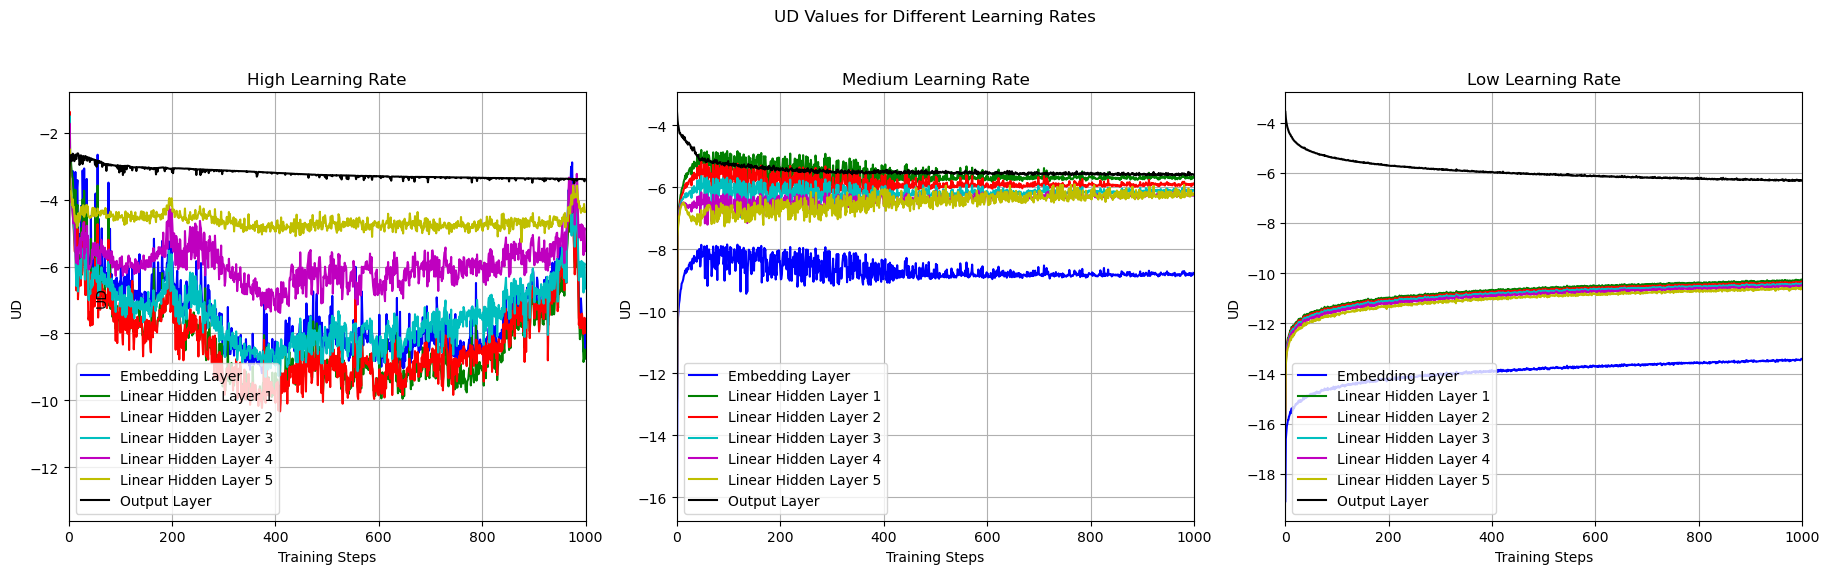

In [12]:
import matplotlib.pyplot as plt

def plot_filtered_ud_values(udLow, udMedium, udHigh, start_step=0):
    plt.figure(figsize=(20, 6))
    
    # Filtering function for embedding, linear layer weights, and output layer weight
    filter_func = lambda ud_step: [ud_step[i] for i in [0, 1, 5, 9, 13, 17, 21]]
    
    # Legends and Titles
    titles = ['High Learning Rate', 'Medium Learning Rate', 'Low Learning Rate']
    all_ud = [udHigh, udMedium, udLow]
    legends = ["Embedding Layer"] + [f"Linear Hidden Layer {i+1}" for i in range(5)] + ["Output Layer"]

    # Colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    # For each learning rate setting
    for i, ud in enumerate(all_ud):
        plt.subplot(1, 3, i+1)
        filtered_ud = [filter_func(ud_step) for ud_step in ud[start_step:]]
        
        # For each layer including embedding and output layer
        for layer_idx in range(len(filtered_ud[0])):
            plt.plot([step[layer_idx] for step in filtered_ud], label=f'Layer {layer_idx+1}', color=colors[layer_idx % len(colors)])
        
        # Styling
        plt.title(titles[i])
        plt.xlabel('Training Steps')
        plt.ylabel('UD')
        plt.legend(legends, loc='lower left')
        plt.xlim([0, 1000])
        plt.grid(True)
    
    # Add a global title and ylabel for all subplots
    plt.suptitle('UD Values for Different Learning Rates')
    plt.figtext(0.08, 0.5, 'UD', va='center', rotation='vertical')
    
    # Show plot
    plt.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
    plt.savefig('learningRateAnalytics.png')
    plt.show()
    

# Call function there is a tradeoff between oscillation stabilitzation and convergence speed. and also speculate that initializing the output layer with a tiny output value reduces its dominance in the loss function, which in turn reduces the oscillation of the hidden layer weights but only for a good learning rate.
plot_filtered_ud_values(udLow, udMedium, udHigh, start_step=0)
